## Import packages

In [47]:
import numpy as np
import pandas as pd
import os


from sklearn import preprocessing
import datetime

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Read Files

In [49]:
os.chdir("/home/srishti/Downloads/av_reco_engine")

In [50]:
problem_csv=pd.read_csv("train/problem_data.csv")
user_csv=pd.read_csv("train/user_data.csv")

train_submissions=pd.read_csv("train/train_submissions.csv")

In [51]:
# also import test
test_submissions=pd.read_csv("test_submissions_NeDLEvX.csv")

In [52]:
user_csv.isnull().sum()
user_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3571 entries, 0 to 3570
Data columns (total 11 columns):
user_id                      3571 non-null object
submission_count             3571 non-null int64
problem_solved               3571 non-null int64
contribution                 3571 non-null int64
country                      2418 non-null object
follower_count               3571 non-null int64
last_online_time_seconds     3571 non-null int64
max_rating                   3571 non-null float64
rating                       3571 non-null float64
rank                         3571 non-null object
registration_time_seconds    3571 non-null int64
dtypes: float64(2), int64(6), object(3)
memory usage: 307.0+ KB


## Data Preparation

In [53]:
# filling nulls in problem level data
nas_in_problem_text = ['tags','level_type']
points_col= ['points']

# replace 'NaN' with 'Unavailable' in these columns
for col in nas_in_problem_text:
    problem_csv[col].fillna('Unavailable',inplace=True)

for col in points_col:
    problem_csv[col].fillna(0,inplace=True)    
    
#similar exercise with user level data
nas_in_user = ['country']

# replace 'NaN' with 'Unavailable' in these columns
for col in nas_in_user:
    user_csv[col].fillna('Unavailable',inplace=True)

In [54]:
train_submissions['ID']= train_submissions['user_id']+"_"+  train_submissions['problem_id'] 
train_data = pd.merge(train_submissions, problem_csv, on = ['problem_id'], how = 'left')
train_data = pd.merge(train_data, user_csv, on = ['user_id'], how = 'left')

In [55]:
# let us also store the target variable
y_train = train_data.attempts_range.values

In [56]:
#create test data
test_data = pd.merge(test_submissions, problem_csv, on = ['problem_id'], how = 'left')
test_data = pd.merge(test_data, user_csv, on = ['user_id'], how = 'left')

#investigating nulls in test df
# in level type
test_nulls=test_data[test_data['level_type'].isnull()]
problem_csv_nulls=problem_csv[problem_csv['level_type'].isnull()]

print(test_nulls['problem_id'].unique())
print(problem_csv_nulls['problem_id'].unique())
#no nulls

[]
[]


In [57]:
cols_order_desired= list(test_data)
cols_order_desired= cols_order_desired+['attempts_range']
cols_order_desired

['ID',
 'user_id',
 'problem_id',
 'level_type',
 'points',
 'tags',
 'submission_count',
 'problem_solved',
 'contribution',
 'country',
 'follower_count',
 'last_online_time_seconds',
 'max_rating',
 'rating',
 'rank',
 'registration_time_seconds',
 'attempts_range']

In [58]:
train_data=train_data[cols_order_desired]
train_data[:3]

,ID,user_id,problem_id,level_type,points,tags,submission_count,problem_solved,contribution,country,follower_count,last_online_time_seconds,max_rating,rating,rank,registration_time_seconds,attempts_range
0,user_232_prob_6507,user_232,prob_6507,B,1000.0,strings,53,47,0,Bangladesh,1,1503633778,307.913,206.709,beginner,1432110935,1
1,user_3568_prob_2994,user_3568,prob_2994,C,1500.0,"brute force,dp",133,118,0,Unavailable,0,1502200122,324.255,235.378,beginner,1454664414,3
2,user_1600_prob_5071,user_1600,prob_5071,A,500.0,implementation,50,44,0,Unavailable,7,1504719542,343.177,229.358,beginner,1473490873,1


In [59]:
# combine train and test datas in to one dataframe
total_df = pd.concat([train_data,test_data]).reset_index(drop=True)
#saving ntrain and a subset for use later
train_subset=total_df[total_df['attempts_range'].notnull()]
ntrain= train_subset.shape[0]

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [60]:
total_df[:5]

,ID,attempts_range,contribution,country,follower_count,last_online_time_seconds,level_type,max_rating,points,problem_id,problem_solved,rank,rating,registration_time_seconds,submission_count,tags,user_id
0,user_232_prob_6507,1.0,0,Bangladesh,1,1503633778,B,307.913,1000.0,prob_6507,47,beginner,206.709,1432110935,53,strings,user_232
1,user_3568_prob_2994,3.0,0,Unavailable,0,1502200122,C,324.255,1500.0,prob_2994,118,beginner,235.378,1454664414,133,"brute force,dp",user_3568
2,user_1600_prob_5071,1.0,0,Unavailable,7,1504719542,A,343.177,500.0,prob_5071,44,beginner,229.358,1473490873,50,implementation,user_1600
3,user_2256_prob_703,1.0,23,Indonesia,40,1505175115,A,436.927,500.0,prob_703,233,intermediate,399.083,1447736644,271,"brute force,implementation",user_2256
4,user_2321_prob_356,1.0,0,India,80,1505421849,D,492.546,2000.0,prob_356,135,advanced,472.190,1437724657,155,"dfs and similar,trees",user_2321


In [61]:
#checking for nulls
total_df.isnull().sum()

ID                               0
attempts_range               66555
contribution                     0
country                          0
follower_count                   0
last_online_time_seconds         0
level_type                       0
max_rating                       0
points                           0
problem_id                       0
problem_solved                   0
rank                             0
rating                           0
registration_time_seconds        0
submission_count                 0
tags                             0
user_id                          0
dtype: int64

## Feature Engineering and Selection

In [62]:
total_df['last_online_time_seconds']=pd.to_datetime(total_df['last_online_time_seconds'],unit='s')
total_df['registration_time_seconds']=pd.to_datetime(total_df['registration_time_seconds'],unit='s')
total_df

,ID,attempts_range,contribution,country,follower_count,last_online_time_seconds,level_type,max_rating,points,problem_id,problem_solved,rank,rating,registration_time_seconds,submission_count,tags,user_id
0,user_232_prob_6507,1.0,0,Bangladesh,1,2017-08-25 04:02:58,B,307.913,1000.0,prob_6507,47,beginner,206.709,2015-05-20 08:35:35,53,strings,user_232
1,user_3568_prob_2994,3.0,0,Unavailable,0,2017-08-08 13:48:42,C,324.255,1500.0,prob_2994,118,beginner,235.378,2016-02-05 09:26:54,133,"brute force,dp",user_3568
2,user_1600_prob_5071,1.0,0,Unavailable,7,2017-09-06 17:39:02,A,343.177,500.0,prob_5071,44,beginner,229.358,2016-09-10 07:01:13,50,implementation,user_1600
3,user_2256_prob_703,1.0,23,Indonesia,40,2017-09-12 00:11:55,A,436.927,500.0,prob_703,233,intermediate,399.083,2015-11-17 05:04:04,271,"brute force,implementation",user_2256
4,user_2321_prob_356,1.0,0,India,80,2017-09-14 20:44:09,D,492.546,2000.0,prob_356,135,advanced,472.190,2015-07-24 07:57:37,155,"dfs and similar,trees",user_2321
5,user_1569_prob_6064,1.0,0,Unavailable,21,2017-09-08 11:33:51,C,462.729,2000.0,prob_6064,161,advanced,462.729,2016-12-04 00:40:45,173,"dp,string suffix structures,trees",user_1569
6,user_3293_prob_1237,1.0,0,Egypt,87,2017-09-16 11:30:09,B,398.222,1000.0,prob_1237,811,intermediate,368.979,2015-08-16 20:15:11,855,implementation,user_3293
7,user_915_prob_4125,2.0,0,Brazil,21,2017-09-16 17:07:05,B,433.486,1000.0,prob_4125,217,intermediate,395.356,2016-05-25 13:27:11,254,"greedy,sortings",user_915
8,user_2032_prob_1943,1.0,0,India,28,2017-09-16 04:04:37,C,387.328,0.0,prob_1943,199,intermediate,387.328,2015-09-27 17:27:05,216,greedy,user_2032
9,user_1410_prob_3935,1.0,0,Bangladesh,56,2017-09-16 10:12:50,C,315.367,1000.0,prob_3935,350,beginner,217.890,2013-11-15 08:47:53,390,"greedy,sortings",user_1410


In [63]:
total_df['current_time']=datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
total_df['current_time'] =  pd.to_datetime(total_df['current_time'], format='%Y-%m-%d %H:%M:%S')
total_df['days_since_registration']= total_df['current_time']-total_df['registration_time_seconds']
total_df['days_since_registration']= total_df['days_since_registration'].dt.days
total_df['mins_since_last_online']= (total_df['current_time']-total_df['last_online_time_seconds']).dt.total_seconds()/60


#drop selected columns- round 0
cols_to_drop0= ['current_time','registration_time_seconds','last_online_time_seconds']
total_df.drop(cols_to_drop0, axis=1, inplace=True)

total_df

,ID,attempts_range,contribution,country,follower_count,level_type,max_rating,points,problem_id,problem_solved,rank,rating,submission_count,tags,user_id,days_since_registration,mins_since_last_online
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,307.913,1000.0,prob_6507,47,beginner,206.709,53,strings,user_232,1312,6.976518e+05
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,324.255,1500.0,prob_2994,118,beginner,235.378,133,"brute force,dp",user_3568,1051,7.215460e+05
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,343.177,500.0,prob_5071,44,beginner,229.358,50,implementation,user_1600,833,6.795557e+05
3,user_2256_prob_703,1.0,23,Indonesia,40,A,436.927,500.0,prob_703,233,intermediate,399.083,271,"brute force,implementation",user_2256,1131,6.719628e+05
4,user_2321_prob_356,1.0,0,India,80,D,492.546,2000.0,prob_356,135,advanced,472.190,155,"dfs and similar,trees",user_2321,1247,6.678506e+05
5,user_1569_prob_6064,1.0,0,Unavailable,21,C,462.729,2000.0,prob_6064,161,advanced,462.729,173,"dp,string suffix structures,trees",user_1569,748,6.770409e+05
6,user_3293_prob_1237,1.0,0,Egypt,87,B,398.222,1000.0,prob_1237,811,intermediate,368.979,855,implementation,user_3293,1223,6.655246e+05
7,user_915_prob_4125,2.0,0,Brazil,21,B,433.486,1000.0,prob_4125,217,intermediate,395.356,254,"greedy,sortings",user_915,941,6.651876e+05
8,user_2032_prob_1943,1.0,0,India,28,C,387.328,0.0,prob_1943,199,intermediate,387.328,216,greedy,user_2032,1181,6.659701e+05
9,user_1410_prob_3935,1.0,0,Bangladesh,56,C,315.367,1000.0,prob_3935,350,beginner,217.890,390,"greedy,sortings",user_1410,1863,6.656019e+05


In [64]:
#creating features 

#number of problems solved by the user of a particular level of a problem
total_df['level_user_unique_problem_count'] = total_df.groupby(['user_id','level_type'])['problem_id'].transform('nunique')

In [65]:
#number of users belonging to a particular rank attempting the given problem
problem_rank_users_count = total_df.groupby(['problem_id','rank'])['user_id'].count()
problem_rank_users_count=pd.DataFrame(problem_rank_users_count)
problem_rank_users_count.reset_index(inplace=True)
colmns_1=['problem_id', 'rank', 'problem_rank_unique_user_count']
problem_rank_users_count.columns=colmns_1

#creating a pivot table out of the above
users_pivot=pd.pivot_table(problem_rank_users_count,index=["problem_id"], columns=["rank"],values=["problem_rank_unique_user_count"],fill_value=0)
users_pivot.reset_index(inplace=True)
colmns_2=['problem_id', 'users_adv','users_beg','users_exp','users_int']
users_pivot.columns=colmns_2
users_pivot[:5]

#merge it into total_df
total_df = pd.merge(total_df, users_pivot, on = ['problem_id'], how = 'left')

In [66]:
#average attempts range for a user for a particular level
total_df['mean_attempts_per_user_level'] = total_df.groupby(['user_id','level_type'])['attempts_range'].transform('mean')
#filling nulls with 0
total_df['mean_attempts_per_user_level'] = total_df['mean_attempts_per_user_level'].fillna(0)

In [67]:
#average attempts range for a user for a questions with particular points
total_df['mean_attempts_per_points_level'] = total_df.groupby(['user_id','points'])['attempts_range'].transform('mean')
#filling nulls with 0
total_df['mean_attempts_per_points_level'] = total_df['mean_attempts_per_points_level'].fillna(0)

In [68]:
#number of problems solved by the user of a particular level of a problem
total_df['points_user_unique_problem_count'] = total_df.groupby(['user_id','points'])['problem_id'].transform('nunique')

In [69]:
#will create percentile buckets for the max rating in a particular level type 
total_df['max_rating_bucket'] =  total_df.groupby(['level_type'])['max_rating'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))

#average attempts range for a user for a particular max_rating bucket
total_df['mean_attempts_per_user_maxrating'] = total_df.groupby(['user_id','max_rating_bucket'])['attempts_range'].transform('mean')
#filling nulls with 0
total_df['mean_attempts_per_user_maxrating'] = total_df['mean_attempts_per_user_maxrating'].fillna(0)

#drop selected columns- round 0.1
cols_to_drop01= ['max_rating','max_rating_bucket']
total_df.drop(cols_to_drop01, axis=1, inplace=True)
total_df[:5]

,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,problem_solved,rank,...,mins_since_last_online,level_user_unique_problem_count,users_adv,users_beg,users_exp,users_int,mean_attempts_per_user_level,mean_attempts_per_points_level,points_user_unique_problem_count,mean_attempts_per_user_maxrating
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,47,beginner,...,697651.750000,16,1,13,0,3,1.875000,1.750000,13,1.870968
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,118,beginner,...,721546.016667,6,30,59,5,87,2.500000,2.666667,4,2.545455
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,44,beginner,...,679555.683333,30,270,908,32,757,1.333333,1.285714,27,1.666667
3,user_2256_prob_703,1.0,23,Indonesia,40,A,500.0,prob_703,233,intermediate,...,671962.800000,23,154,142,32,237,1.300000,1.117647,20,1.540541
4,user_2321_prob_356,1.0,0,India,80,D,2000.0,prob_356,135,advanced,...,667850.566667,11,8,2,0,11,1.500000,1.666667,7,1.695652


In [70]:
# average submission per problem
total_df['avg_submissions_per_problem'] = total_df['submission_count']//total_df['problem_solved']

#drop selected columns- round 1
cols_to_drop1= ['submission_count','problem_solved']
total_df.drop(cols_to_drop1, axis=1, inplace=True)
total_df[:5]

,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,rank,rating,...,level_user_unique_problem_count,users_adv,users_beg,users_exp,users_int,mean_attempts_per_user_level,mean_attempts_per_points_level,points_user_unique_problem_count,mean_attempts_per_user_maxrating,avg_submissions_per_problem
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,beginner,206.709,...,16,1,13,0,3,1.875000,1.750000,13,1.870968,1
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,beginner,235.378,...,6,30,59,5,87,2.500000,2.666667,4,2.545455,1
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,beginner,229.358,...,30,270,908,32,757,1.333333,1.285714,27,1.666667,1
3,user_2256_prob_703,1.0,23,Indonesia,40,A,500.0,prob_703,intermediate,399.083,...,23,154,142,32,237,1.300000,1.117647,20,1.540541,1
4,user_2321_prob_356,1.0,0,India,80,D,2000.0,prob_356,advanced,472.190,...,11,8,2,0,11,1.500000,1.666667,7,1.695652,1


In [71]:
test=total_df['tags'].unique()
print(test.shape[0])
arr_strings=[]


for i in range(0,(test.shape[0]-1)) :
    test_part=str(test[i]).split(",")
    for j in range(0,len(test_part)):
        arr_strings.append(test_part[j])
        
final_list_of_terms= list(set(arr_strings))
terms_df=pd.DataFrame(final_list_of_terms)
terms_df.columns= ['terms']

def replace_asterisk(val):
    if isinstance(val, str):
        return(val.replace('*', ''))
    else:
        return(val)    

def replace_hyphen(val):
    if isinstance(val, str):
        return(val.replace('-', '_'))
    else:
        return(val)    

def remove_extraspace(val):
        if isinstance(val, str):
            return(val.strip())
        else:
            return(val) 

def replace_space(val):
        if isinstance(val, str):
            return(val.replace(' ', '_'))
        else:
            return(val)
        
def add_flag(val):
        prefix= "flag_"
        return prefix+val       

terms_df['terms'] = terms_df['terms'].apply(replace_asterisk)
terms_df['terms'] = terms_df['terms'].apply(replace_hyphen)
terms_df['terms'] = terms_df['terms'].apply(remove_extraspace)
terms_df['terms'] = terms_df['terms'].apply(replace_space)
terms_df['terms'] = terms_df['terms'].apply(add_flag)

terms_amended=terms_df['terms'].tolist()        

876


In [72]:
print(len(terms_amended))
terms_amended

37


['flag_string_suffix_structures',
 'flag_dp',
 'flag_binary_search',
 'flag_implementation',
 'flag_schedules',
 'flag_expression_parsing',
 'flag_trees',
 'flag_hashing',
 'flag_ternary_search',
 'flag_Unavailable',
 'flag_math',
 'flag_shortest_paths',
 'flag_fft',
 'flag_chinese_remainder_theorem',
 'flag_divide_and_conquer',
 'flag_meet_in_the_middle',
 'flag_dfs_and_similar',
 'flag_graph_matchings',
 'flag_games',
 'flag_constructive_algorithms',
 'flag_probabilities',
 'flag_brute_force',
 'flag_flows',
 'flag_two_pointers',
 'flag_graphs',
 'flag_sortings',
 'flag_strings',
 'flag_bitmasks',
 'flag_geometry',
 'flag_dsu',
 'flag_2_sat',
 'flag_data_structures',
 'flag_greedy',
 'flag_matrices',
 'flag_number_theory',
 'flag_combinatorics',
 'flag_special']

In [73]:
total_df_copy=total_df.copy()

In [74]:
#create flag columns for presence of tags
for idx,val in enumerate(terms_amended):
    #get the term being checked
    str_check=final_list_of_terms[idx]
    #associated column name
    col_name= terms_amended[idx]
    #populate the column: if present 1, else 0
    total_df_copy[col_name]=total_df_copy['tags'].apply(lambda x: 0 if str(x).find(str_check, 0)==-1 else 1)
    
total_df_copy[:10]   

,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,rank,rating,...,flag_bitmasks,flag_geometry,flag_dsu,flag_2_sat,flag_data_structures,flag_greedy,flag_matrices,flag_number_theory,flag_combinatorics,flag_special
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,beginner,206.709,...,0,0,0,0,0,0,0,0,0,0
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,beginner,235.378,...,0,0,0,0,0,0,0,0,0,0
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,beginner,229.358,...,0,0,0,0,0,0,0,0,0,0
3,user_2256_prob_703,1.0,23,Indonesia,40,A,500.0,prob_703,intermediate,399.083,...,0,0,0,0,0,0,0,0,0,0
4,user_2321_prob_356,1.0,0,India,80,D,2000.0,prob_356,advanced,472.190,...,0,0,0,0,0,0,0,0,0,0
5,user_1569_prob_6064,1.0,0,Unavailable,21,C,2000.0,prob_6064,advanced,462.729,...,0,0,0,0,0,0,0,0,0,0
6,user_3293_prob_1237,1.0,0,Egypt,87,B,1000.0,prob_1237,intermediate,368.979,...,0,0,0,0,0,0,0,0,0,0
7,user_915_prob_4125,2.0,0,Brazil,21,B,1000.0,prob_4125,intermediate,395.356,...,0,0,0,0,0,1,0,0,0,0
8,user_2032_prob_1943,1.0,0,India,28,C,0.0,prob_1943,intermediate,387.328,...,0,0,0,0,0,1,0,0,0,0
9,user_1410_prob_3935,1.0,0,Bangladesh,56,C,1000.0,prob_3935,beginner,217.890,...,0,0,0,0,0,1,0,0,0,0


In [75]:
total_df_copy.info()
total_df_copy.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221850 entries, 0 to 221849
Data columns (total 61 columns):
ID                                  221850 non-null object
attempts_range                      155295 non-null float64
contribution                        221850 non-null int64
country                             221850 non-null object
follower_count                      221850 non-null int64
level_type                          221850 non-null object
points                              221850 non-null float64
problem_id                          221850 non-null object
rank                                221850 non-null object
rating                              221850 non-null float64
tags                                221850 non-null object
user_id                             221850 non-null object
days_since_registration             221850 non-null int64
mins_since_last_online              221850 non-null float64
level_user_unique_problem_count     221850 non-null int64
user

ID                                      0
attempts_range                      66555
contribution                            0
country                                 0
follower_count                          0
level_type                              0
points                                  0
problem_id                              0
rank                                    0
rating                                  0
tags                                    0
user_id                                 0
days_since_registration                 0
mins_since_last_online                  0
level_user_unique_problem_count         0
users_adv                               0
users_beg                               0
users_exp                               0
users_int                               0
mean_attempts_per_user_level            0
mean_attempts_per_points_level          0
points_user_unique_problem_count        0
mean_attempts_per_user_maxrating        0
avg_submissions_per_problem       

In [76]:
total_df_copy[:3]

,ID,attempts_range,contribution,country,follower_count,level_type,points,problem_id,rank,rating,...,flag_bitmasks,flag_geometry,flag_dsu,flag_2_sat,flag_data_structures,flag_greedy,flag_matrices,flag_number_theory,flag_combinatorics,flag_special
0,user_232_prob_6507,1.0,0,Bangladesh,1,B,1000.0,prob_6507,beginner,206.709,...,0,0,0,0,0,0,0,0,0,0
1,user_3568_prob_2994,3.0,0,Unavailable,0,C,1500.0,prob_2994,beginner,235.378,...,0,0,0,0,0,0,0,0,0,0
2,user_1600_prob_5071,1.0,0,Unavailable,7,A,500.0,prob_5071,beginner,229.358,...,0,0,0,0,0,0,0,0,0,0


In [77]:
flag_col = [col for col in total_df_copy if col.startswith('flag')]
add_col = ['problem_id','level_type','points']
add_col.extend(flag_col)
add_col
problem_cluster= total_df_copy[add_col]

# create a list of ordinal variables
ordinal_variables0=['level_type']
# label encoder
le = preprocessing.LabelEncoder()

for c in ordinal_variables0:
    le.fit(problem_cluster[c])
    problem_cluster[c] = le.transform(problem_cluster[c])


problem_cluster[:5]    

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,problem_id,level_type,points,flag_string_suffix_structures,flag_dp,flag_binary_search,flag_implementation,flag_schedules,flag_expression_parsing,flag_trees,...,flag_bitmasks,flag_geometry,flag_dsu,flag_2_sat,flag_data_structures,flag_greedy,flag_matrices,flag_number_theory,flag_combinatorics,flag_special
0,prob_6507,1,1000.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,prob_2994,2,1500.0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,prob_5071,0,500.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,prob_703,0,500.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,prob_356,3,2000.0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [78]:
problem_cluster=problem_cluster.drop_duplicates(subset='problem_id', keep='first', inplace=False)

In [33]:
%load_ext rpy2.ipython

In [34]:
%%R -i problem_cluster -w 5 -h 5 --units in -r 200
#install.packages("cba")
library("cba")

######################## ROCK CLUSTERING #############################
df<- problem_cluster
indexed_df <- df[-1]
row.names(indexed_df) <- df$problem_id
#print(indexed_df)
rc<- rockCluster(indexed_df, n=5, theta = 0.3, fun = "dist", funArgs = list(method="binary"))

print(rc)
rp <- predict(rc, indexed_df)
table(indexed_df$level_type, rp$cl)

/home/srishti/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/home/srishti/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: grid

  warnings.warn(x, RRuntimeWarning)
/home/srishti/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: proxy

  warnings.warn(x, RRuntimeWarning)
/home/srishti/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘proxy’


  warnings.warn(x, RRuntimeWarning)
/home/srishti/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    as.dist, dist


  warnings.warn(x, RRunt

Clustering:
computing distances ...
computing links ...
computing clusters ...
 data: x 
 beta: 0.7 
theta: 0.3 
  fun: dist 
 args: list(method = "binary") 
   1    2    3    4    5 
5175    1 1034    1    1 
dropping 3 clusters
computing distances ...
computing classes ...
    
       1   3
  0  623 390
  1  606 375
  2  537 341
  3  467 344
  4  417 336
  5   94 297
  6   26 282
  7    9 241
  8    4 228
  9    5 185
  10   3 142
  11   2  94
  12   2  33
  13   1   8
  14  26  94


In [35]:
%%R -i problem_cluster -w 5 -h 5 --units in -r 200
#install.packages("cba")
library("cba")
#install.packages("cluster")
library("cluster")

############################# HIERARCHICAL POST DAISY ###################################
df<- problem_cluster
indexed_df <- df[-1]
row.names(indexed_df) <- df$problem_id
#print(indexed_df)
indexed_df$level_type <- as.ordered(indexed_df$level_type)

# for (i in names(indexed_df)){
# print(table(indexed_df[[i]]))} ## since distrbution of 0s and 1s in presence of word flags, we will use asymm for the flag

#using gower distance for the mixed variables
daisy_cl<- daisy(indexed_df, metric = c("gower"),
      stand = FALSE, type = list(asymm = (3:39), ordratio = 1), weights = rep.int(1, ncol(indexed_df)))

summary(daisy_cl)
H.fit <- hclust(daisy_cl, method="ward")
#plotting the dendogram
#plot(H.fit)
#groups <- cutree(H.fit, k=5) # cut tree into 5 clusters--based on the dendogram
groups <- cutree(H.fit, k=4) # checking with 4-- seems more cohesive-- will go ahead with this for now

# 2D representation of the Segmentation:
# clusplot(indexed_df, groups, color=TRUE, shade=TRUE,
#          labels=2, lines=0, main= 'Customer segments')

# Merge Data with base dataframe

cluster.deals<-merge(indexed_df[1:2],groups,by.x = "row.names", by.y = "row.names")

colnames(cluster.deals)<-c("problem","level","points","Cluster")
print(table(cluster.deals$level,cluster.deals$Cluster))



/home/srishti/.local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The "ward" method has been renamed to "ward.D"; note new "ward.D2"

  warnings.warn(x, RRuntimeWarning)


    
       1   2   3   4
  0  445 188   0 380
  1  563  78   0 340
  2  551  13   0 314
  3  485   3   0 323
  4  442   2   1 308
  5  111   1   0 279
  6   38   3 265   2
  7   17   1 232   0
  8    9   1 222   0
  9    8   0 182   0
  10   4   0 141   0
  11   3   1  92   0
  12   3   0  32   0
  13   2   0   7   0
  14  30   2  88   0


In [37]:
%%R -i problem_cluster -w 5 -h 5 --units in -r 200
#install.packages("cba")
library("cba")
#install.packages("cluster")
library("cluster")
library("dplyr")

############################# PAM POST DAISY ###################################
df<- problem_cluster
indexed_df <- df[-1]
row.names(indexed_df) <- df$problem_id
#print(indexed_df)
indexed_df$level_type <- as.ordered(indexed_df$level_type)

# for (i in names(indexed_df)){
# print(table(indexed_df[[i]]))} ## since distrbution of 0s and 1s in presence of word flags, we will use asymm for the flag

daisy_cl<- daisy(indexed_df, metric = c("gower"),
      stand = FALSE, type = list(asymm = (3:39), ordratio = 1), weights = rep.int(1, ncol(indexed_df)))

gower_mat <- as.matrix(daisy_cl)

# sil_width <- c(NA)

# for(i in 2:10){
#   pam_fit <- pam(daisy_cl,
#                  diss = TRUE,
#                  k = i)
  
#   sil_width[i] <- pam_fit$silinfo$avg.width
#   }

# Plot sihouette width (higher is better)

# plot(1:10, sil_width,
#      xlab = "Number of clusters",
#      ylab = "Silhouette Width")
# lines(1:10, sil_width)
# max sil width comes for k=4 i.e o,50

pam_fit <- pam(daisy_cl, diss = TRUE, k = 4)

#print(pam_fit)

#some stats of the clusters
# pam_results <- indexed_df %>%
#   mutate(cluster = pam_fit$clustering) %>%
#   group_by(cluster) %>%
#   do(the_summary = summary(.))

# pam_results$the_summary

pam_clusters<-merge(indexed_df[1:2],pam_fit$clustering,by.x = "row.names", by.y = "row.names")

colnames(pam_clusters)<-c("problem","level","points","Cluster")
#print(pam_clusters)
print(table(pam_clusters$level,pam_clusters$Cluster))

write.csv(pam_clusters, file = "problem_cluster.csv",row.names=FALSE)

    
       1   2   3   4
  0  488  16 129 380
  1  421  68 152 340
  2  132 241 165 340
  3   54 292 114 351
  4   27 308  75 343
  5   13  58  16 304
  6    5  15   5 283
  7    4   4   1 241
  8    2   2   1 227
  9    2   2   1 185
  10   1   1   2 141
  11   1   1   1  93
  12   0   0   2  33
  13   0   0   1   8
  14   3   5   5 107


In [79]:
problem_cluster_csv=pd.read_csv("problem_cluster.csv")
problem_cluster_csv[:3]

,problem,level,points,Cluster
0,prob_1,0,0,4
1,prob_10,8,0,4
2,prob_100,1,0,4


In [80]:
print(total_df_copy.shape)
total_df_copy = pd.merge(total_df_copy, problem_cluster_csv, left_on = ['problem_id'], right_on=['problem'], how = 'left')
print(total_df_copy.shape)

(221850, 61)
(221850, 65)


In [81]:
#drop selected columns - round 2
cols_to_drop2= ['user_id', 'problem_id']
cols_to_drop22= ['user_id', 'problem_id','level','points_y','problem']
total_df_copy.drop(cols_to_drop22, axis=1, inplace=True)
train_data.drop(cols_to_drop2, axis=1, inplace=True)

#drop selected columns- round 3
cols_to_drop3= ['tags']
total_df_copy.drop(cols_to_drop3, axis=1, inplace=True)

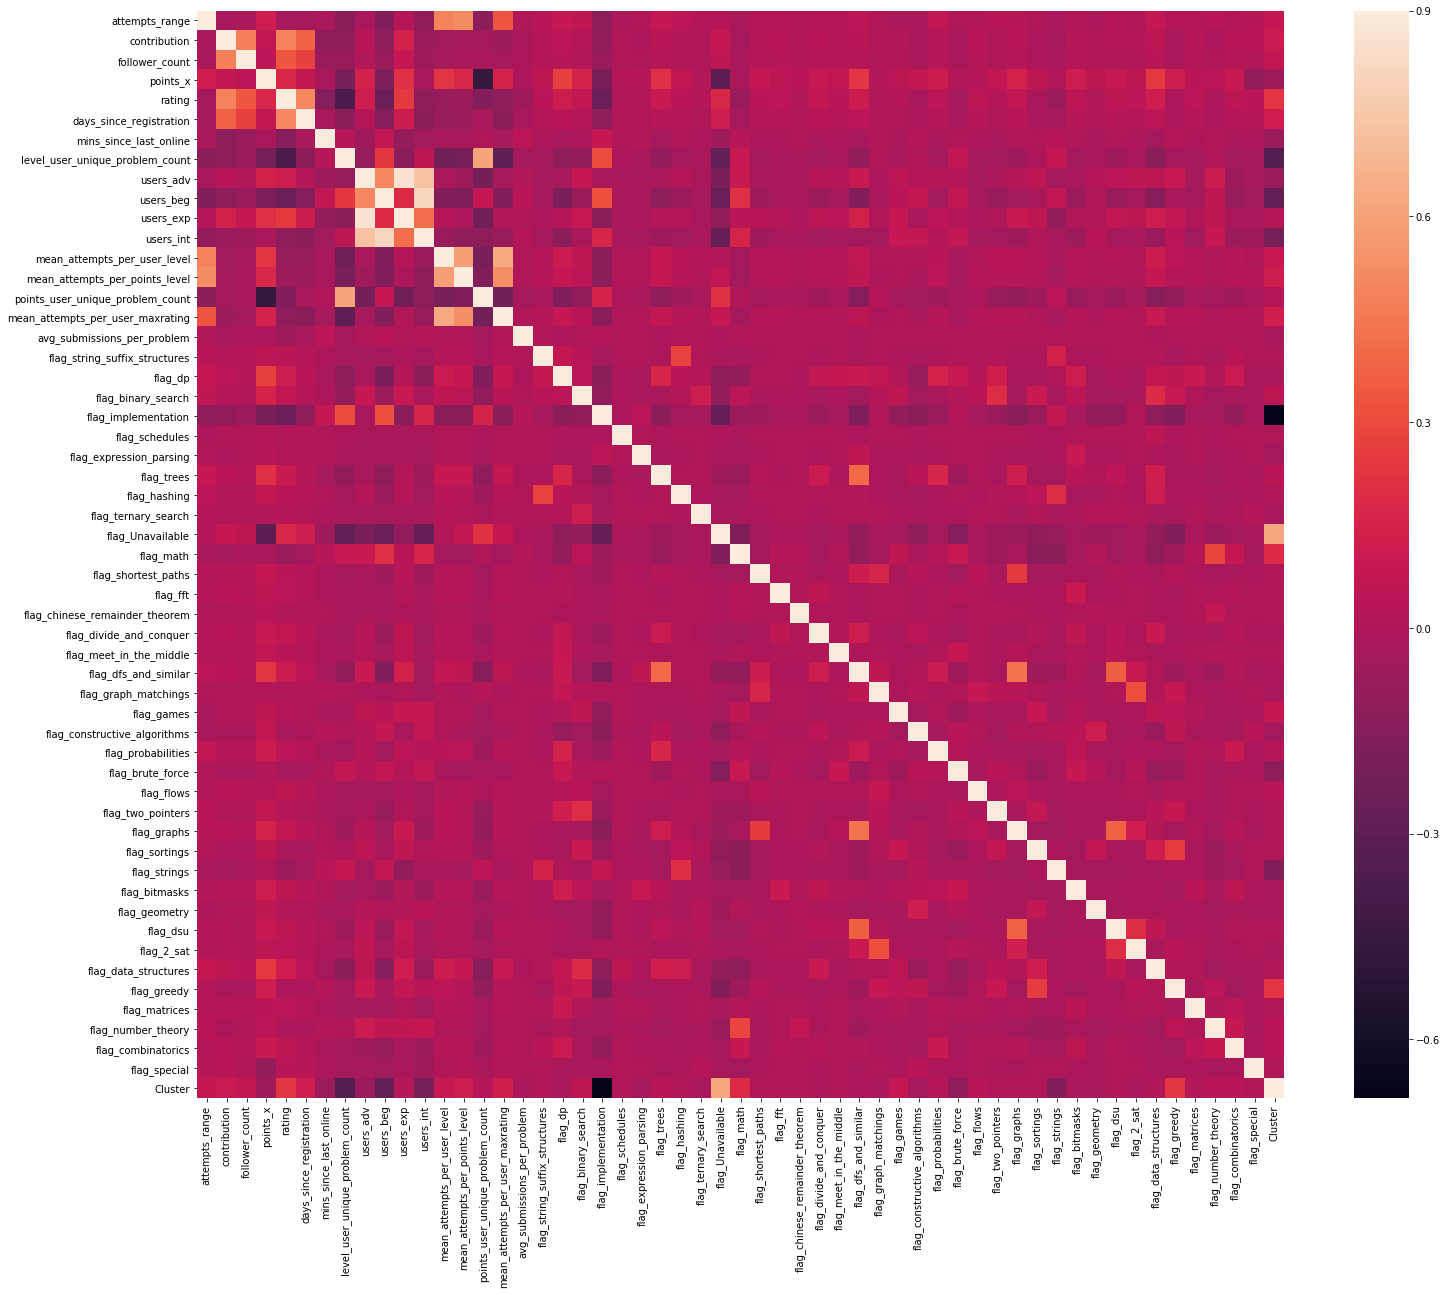

In [82]:
corr_matrix = total_df_copy.corr()
plt.subplots(figsize=(25,20))
sns.heatmap(corr_matrix, vmax=0.9, square=True)

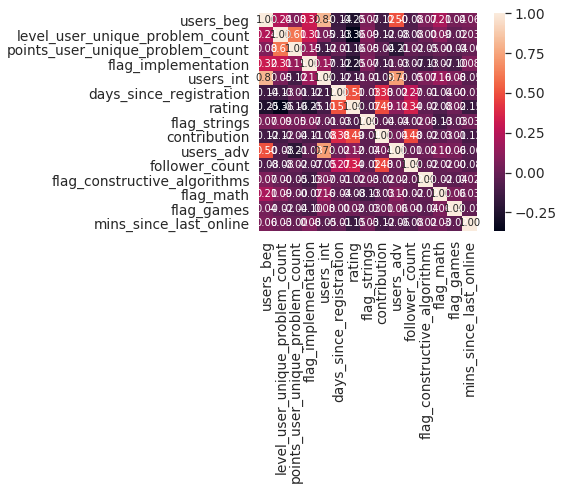

In [83]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
cols = corr_matrix.nsmallest(k, 'attempts_range')['attempts_range'].index
cm = np.corrcoef(total_df_copy[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [84]:
#create index using 'id'
#this is because the id column will not be used in the algorithm. yet it is needed to identify the unique combination
input_df= total_df_copy.set_index('ID')


# dropping attempts range
input_df.drop(['attempts_range'], axis=1, inplace=True)  

#check for nulls again
input_df.isnull().sum()

contribution                        0
country                             0
follower_count                      0
level_type                          0
points_x                            0
rank                                0
rating                              0
days_since_registration             0
mins_since_last_online              0
level_user_unique_problem_count     0
users_adv                           0
users_beg                           0
users_exp                           0
users_int                           0
mean_attempts_per_user_level        0
mean_attempts_per_points_level      0
points_user_unique_problem_count    0
mean_attempts_per_user_maxrating    0
avg_submissions_per_problem         0
flag_string_suffix_structures       0
flag_dp                             0
flag_binary_search                  0
flag_implementation                 0
flag_schedules                      0
flag_expression_parsing             0
flag_trees                          0
flag_hashing

In [85]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221850 entries, user_232_prob_6507 to user_474_prob_6497
Data columns (total 57 columns):
contribution                        221850 non-null int64
country                             221850 non-null object
follower_count                      221850 non-null int64
level_type                          221850 non-null object
points_x                            221850 non-null float64
rank                                221850 non-null object
rating                              221850 non-null float64
days_since_registration             221850 non-null int64
mins_since_last_online              221850 non-null float64
level_user_unique_problem_count     221850 non-null int64
users_adv                           221850 non-null int64
users_beg                           221850 non-null int64
users_exp                           221850 non-null int64
users_int                           221850 non-null int64
mean_attempts_per_user_level        221850 n

In [86]:
# create a list of ordinal variables
ordinal_variables=['level_type','rank']
# label encoder
le = preprocessing.LabelEncoder()

for c in ordinal_variables:
    le.fit(input_df[c])
    input_df[c] = le.transform(input_df[c])
    
    
# create a list of categorical columns for one hot encoding
cat_variables= ['country']

# One-Hot encoding to convert categorical columns to numeric
print('start one-hot encoding')

input_df = pd.get_dummies(input_df, prefix = cat_variables,
                         columns = cat_variables)

print('one-hot encoding done')

  

start one-hot encoding
one-hot encoding done


In [87]:
input_df[:10]

,contribution,follower_count,level_type,points_x,rank,rating,days_since_registration,mins_since_last_online,level_user_unique_problem_count,users_adv,...,country_Trinidad and Tobago,country_Tunisia,country_Turkmenistan,country_Ukraine,country_Unavailable,country_United Kingdom,country_United States,country_Uzbekistan,country_Venezuela,country_Vietnam
ID,,,,,,,,,,,,,,,,,,,,,
user_232_prob_6507,0,1,1,1000.0,1,206.709,1312,697651.750000,16,1,...,0,0,0,0,0,0,0,0,0,0
user_3568_prob_2994,0,0,2,1500.0,1,235.378,1051,721546.016667,6,30,...,0,0,0,0,1,0,0,0,0,0
user_1600_prob_5071,0,7,0,500.0,1,229.358,833,679555.683333,30,270,...,0,0,0,0,1,0,0,0,0,0
user_2256_prob_703,23,40,0,500.0,3,399.083,1131,671962.800000,23,154,...,0,0,0,0,0,0,0,0,0,0
user_2321_prob_356,0,80,3,2000.0,0,472.190,1247,667850.566667,11,8,...,0,0,0,0,0,0,0,0,0,0
user_1569_prob_6064,0,21,2,2000.0,0,462.729,748,677040.866667,17,1,...,0,0,0,0,1,0,0,0,0,0
user_3293_prob_1237,0,87,1,1000.0,3,368.979,1223,665524.566667,24,1,...,0,0,0,0,0,0,0,0,0,0
user_915_prob_4125,0,21,1,1000.0,3,395.356,941,665187.633333,24,30,...,0,0,0,0,0,0,0,0,0,0
user_2032_prob_1943,0,28,2,0.0,3,387.328,1181,665970.100000,33,3,...,0,0,0,0,0,0,0,0,0,0


## Model Creation and Predictions

In [88]:
# Splitting the train and test datasets
train = input_df[:ntrain]
test = input_df[ntrain:]

In [89]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import f1_score

In [90]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 

In [91]:
knn = KNeighborsClassifier(n_neighbors = 3).fit(train.values, y_train) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(test.values)  
cm_knn = confusion_matrix(y_train, knn.predict(train.values))

f1_score(y_train, knn.predict(train.values), average='weighted')

0.6444440637327586

In [92]:
pd.crosstab(y_train, knn.predict(train.values)) # y_train in rows, prediction in columns

col_0,1,2,3,4,5,6
row_0,,,,,,
1,74799,7186,660,93,23,43
2,20081,26474,570,112,23,60
3,8226,2608,3232,42,12,23
4,3278,1416,200,589,3,13
5,1508,690,135,14,140,9
6,1642,800,173,27,9,382


In [93]:
knn.classes_

array([1, 2, 3, 4, 5, 6])

In [94]:
import xgboost as xgb

In [95]:
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, n_estimators=2000, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

In [96]:
xgb_model=xgb_model.fit(train.values, y_train,
                        eval_set=[(train.values, y_train)],
                        eval_metric='mlogloss',verbose=True) 
xgb_predictions = xgb_model.predict(test.values)

[0]	validation_0-mlogloss:1.70718
[1]	validation_0-mlogloss:1.64158
[2]	validation_0-mlogloss:1.57773
[3]	validation_0-mlogloss:1.52259
[4]	validation_0-mlogloss:1.47373
[5]	validation_0-mlogloss:1.43096
[6]	validation_0-mlogloss:1.39301
[7]	validation_0-mlogloss:1.35875
[8]	validation_0-mlogloss:1.32668
[9]	validation_0-mlogloss:1.29783
[10]	validation_0-mlogloss:1.27202
[11]	validation_0-mlogloss:1.24828
[12]	validation_0-mlogloss:1.22598
[13]	validation_0-mlogloss:1.20588
[14]	validation_0-mlogloss:1.18839
[15]	validation_0-mlogloss:1.17159
[16]	validation_0-mlogloss:1.1561
[17]	validation_0-mlogloss:1.14163
[18]	validation_0-mlogloss:1.12864
[19]	validation_0-mlogloss:1.11619
[20]	validation_0-mlogloss:1.10454
[21]	validation_0-mlogloss:1.09403
[22]	validation_0-mlogloss:1.08399
[23]	validation_0-mlogloss:1.07481
[24]	validation_0-mlogloss:1.0663
[25]	validation_0-mlogloss:1.05835
[26]	validation_0-mlogloss:1.05104
[27]	validation_0-mlogloss:1.04416
[28]	validation_0-mlogloss:1.037

[227]	validation_0-mlogloss:0.875657
[228]	validation_0-mlogloss:0.875444
[229]	validation_0-mlogloss:0.875169
[230]	validation_0-mlogloss:0.874972
[231]	validation_0-mlogloss:0.874774
[232]	validation_0-mlogloss:0.874588
[233]	validation_0-mlogloss:0.874377
[234]	validation_0-mlogloss:0.874131
[235]	validation_0-mlogloss:0.873779
[236]	validation_0-mlogloss:0.873524
[237]	validation_0-mlogloss:0.873305
[238]	validation_0-mlogloss:0.873126
[239]	validation_0-mlogloss:0.872963
[240]	validation_0-mlogloss:0.872733
[241]	validation_0-mlogloss:0.872557
[242]	validation_0-mlogloss:0.872409
[243]	validation_0-mlogloss:0.872156
[244]	validation_0-mlogloss:0.871866
[245]	validation_0-mlogloss:0.871636
[246]	validation_0-mlogloss:0.871466
[247]	validation_0-mlogloss:0.871225
[248]	validation_0-mlogloss:0.870979
[249]	validation_0-mlogloss:0.870719
[250]	validation_0-mlogloss:0.870503
[251]	validation_0-mlogloss:0.870315
[252]	validation_0-mlogloss:0.870071
[253]	validation_0-mlogloss:0.86987
[2

[450]	validation_0-mlogloss:0.832934
[451]	validation_0-mlogloss:0.832755
[452]	validation_0-mlogloss:0.832542
[453]	validation_0-mlogloss:0.83236
[454]	validation_0-mlogloss:0.832207
[455]	validation_0-mlogloss:0.832073
[456]	validation_0-mlogloss:0.831916
[457]	validation_0-mlogloss:0.831726
[458]	validation_0-mlogloss:0.831596
[459]	validation_0-mlogloss:0.831484
[460]	validation_0-mlogloss:0.831308
[461]	validation_0-mlogloss:0.831153
[462]	validation_0-mlogloss:0.830961
[463]	validation_0-mlogloss:0.830832
[464]	validation_0-mlogloss:0.830665
[465]	validation_0-mlogloss:0.830496
[466]	validation_0-mlogloss:0.830383
[467]	validation_0-mlogloss:0.830251
[468]	validation_0-mlogloss:0.830099
[469]	validation_0-mlogloss:0.829898
[470]	validation_0-mlogloss:0.829756
[471]	validation_0-mlogloss:0.829571
[472]	validation_0-mlogloss:0.829344
[473]	validation_0-mlogloss:0.829217
[474]	validation_0-mlogloss:0.829077
[475]	validation_0-mlogloss:0.828973
[476]	validation_0-mlogloss:0.828805
[4

[673]	validation_0-mlogloss:0.800259
[674]	validation_0-mlogloss:0.800114
[675]	validation_0-mlogloss:0.799996
[676]	validation_0-mlogloss:0.799875
[677]	validation_0-mlogloss:0.799751
[678]	validation_0-mlogloss:0.799617
[679]	validation_0-mlogloss:0.799543
[680]	validation_0-mlogloss:0.799429
[681]	validation_0-mlogloss:0.799315
[682]	validation_0-mlogloss:0.799197
[683]	validation_0-mlogloss:0.799055
[684]	validation_0-mlogloss:0.798906
[685]	validation_0-mlogloss:0.798727
[686]	validation_0-mlogloss:0.798613
[687]	validation_0-mlogloss:0.798498
[688]	validation_0-mlogloss:0.798381
[689]	validation_0-mlogloss:0.798258
[690]	validation_0-mlogloss:0.798139
[691]	validation_0-mlogloss:0.798007
[692]	validation_0-mlogloss:0.797899
[693]	validation_0-mlogloss:0.797765
[694]	validation_0-mlogloss:0.797612
[695]	validation_0-mlogloss:0.797492
[696]	validation_0-mlogloss:0.797338
[697]	validation_0-mlogloss:0.797208
[698]	validation_0-mlogloss:0.797078
[699]	validation_0-mlogloss:0.79695
[7

[896]	validation_0-mlogloss:0.771912
[897]	validation_0-mlogloss:0.771821
[898]	validation_0-mlogloss:0.77172
[899]	validation_0-mlogloss:0.771612
[900]	validation_0-mlogloss:0.77148
[901]	validation_0-mlogloss:0.771361
[902]	validation_0-mlogloss:0.77123
[903]	validation_0-mlogloss:0.771103
[904]	validation_0-mlogloss:0.770995
[905]	validation_0-mlogloss:0.770871
[906]	validation_0-mlogloss:0.770734
[907]	validation_0-mlogloss:0.770607
[908]	validation_0-mlogloss:0.770485
[909]	validation_0-mlogloss:0.770343
[910]	validation_0-mlogloss:0.770235
[911]	validation_0-mlogloss:0.770119
[912]	validation_0-mlogloss:0.770033
[913]	validation_0-mlogloss:0.769905
[914]	validation_0-mlogloss:0.769784
[915]	validation_0-mlogloss:0.769676
[916]	validation_0-mlogloss:0.769559
[917]	validation_0-mlogloss:0.769425
[918]	validation_0-mlogloss:0.769323
[919]	validation_0-mlogloss:0.769193
[920]	validation_0-mlogloss:0.7691
[921]	validation_0-mlogloss:0.768988
[922]	validation_0-mlogloss:0.768839
[923]	

[1115]	validation_0-mlogloss:0.746757
[1116]	validation_0-mlogloss:0.746658
[1117]	validation_0-mlogloss:0.74653
[1118]	validation_0-mlogloss:0.746397
[1119]	validation_0-mlogloss:0.746278
[1120]	validation_0-mlogloss:0.746182
[1121]	validation_0-mlogloss:0.746065
[1122]	validation_0-mlogloss:0.745969
[1123]	validation_0-mlogloss:0.745834
[1124]	validation_0-mlogloss:0.745754
[1125]	validation_0-mlogloss:0.745655
[1126]	validation_0-mlogloss:0.745555
[1127]	validation_0-mlogloss:0.74544
[1128]	validation_0-mlogloss:0.745309
[1129]	validation_0-mlogloss:0.745198
[1130]	validation_0-mlogloss:0.745065
[1131]	validation_0-mlogloss:0.744973
[1132]	validation_0-mlogloss:0.744851
[1133]	validation_0-mlogloss:0.744744
[1134]	validation_0-mlogloss:0.744637
[1135]	validation_0-mlogloss:0.744496
[1136]	validation_0-mlogloss:0.744346
[1137]	validation_0-mlogloss:0.744242
[1138]	validation_0-mlogloss:0.744126
[1139]	validation_0-mlogloss:0.744035
[1140]	validation_0-mlogloss:0.743958
[1141]	validat

[1332]	validation_0-mlogloss:0.724175
[1333]	validation_0-mlogloss:0.724067
[1334]	validation_0-mlogloss:0.723965
[1335]	validation_0-mlogloss:0.723872
[1336]	validation_0-mlogloss:0.723782
[1337]	validation_0-mlogloss:0.723649
[1338]	validation_0-mlogloss:0.723562
[1339]	validation_0-mlogloss:0.723462
[1340]	validation_0-mlogloss:0.723359
[1341]	validation_0-mlogloss:0.723247
[1342]	validation_0-mlogloss:0.723143
[1343]	validation_0-mlogloss:0.723031
[1344]	validation_0-mlogloss:0.722926
[1345]	validation_0-mlogloss:0.722829
[1346]	validation_0-mlogloss:0.722704
[1347]	validation_0-mlogloss:0.722606
[1348]	validation_0-mlogloss:0.722499
[1349]	validation_0-mlogloss:0.722396
[1350]	validation_0-mlogloss:0.722313
[1351]	validation_0-mlogloss:0.722228
[1352]	validation_0-mlogloss:0.722156
[1353]	validation_0-mlogloss:0.722066
[1354]	validation_0-mlogloss:0.72199
[1355]	validation_0-mlogloss:0.721878
[1356]	validation_0-mlogloss:0.721768
[1357]	validation_0-mlogloss:0.721646
[1358]	valida

[1549]	validation_0-mlogloss:0.703288
[1550]	validation_0-mlogloss:0.7032
[1551]	validation_0-mlogloss:0.703112
[1552]	validation_0-mlogloss:0.703013
[1553]	validation_0-mlogloss:0.702916
[1554]	validation_0-mlogloss:0.702801
[1555]	validation_0-mlogloss:0.702723
[1556]	validation_0-mlogloss:0.702632
[1557]	validation_0-mlogloss:0.702529
[1558]	validation_0-mlogloss:0.702444
[1559]	validation_0-mlogloss:0.702366
[1560]	validation_0-mlogloss:0.702285
[1561]	validation_0-mlogloss:0.702194
[1562]	validation_0-mlogloss:0.702115
[1563]	validation_0-mlogloss:0.702029
[1564]	validation_0-mlogloss:0.70193
[1565]	validation_0-mlogloss:0.701826
[1566]	validation_0-mlogloss:0.701747
[1567]	validation_0-mlogloss:0.701646
[1568]	validation_0-mlogloss:0.701556
[1569]	validation_0-mlogloss:0.701458
[1570]	validation_0-mlogloss:0.701368
[1571]	validation_0-mlogloss:0.701238
[1572]	validation_0-mlogloss:0.701164
[1573]	validation_0-mlogloss:0.701075
[1574]	validation_0-mlogloss:0.700982
[1575]	validati

[1766]	validation_0-mlogloss:0.683754
[1767]	validation_0-mlogloss:0.683662
[1768]	validation_0-mlogloss:0.683574
[1769]	validation_0-mlogloss:0.683503
[1770]	validation_0-mlogloss:0.683416
[1771]	validation_0-mlogloss:0.683333
[1772]	validation_0-mlogloss:0.683263
[1773]	validation_0-mlogloss:0.683197
[1774]	validation_0-mlogloss:0.683085
[1775]	validation_0-mlogloss:0.682995
[1776]	validation_0-mlogloss:0.682906
[1777]	validation_0-mlogloss:0.68281
[1778]	validation_0-mlogloss:0.682729
[1779]	validation_0-mlogloss:0.682628
[1780]	validation_0-mlogloss:0.682512
[1781]	validation_0-mlogloss:0.682429
[1782]	validation_0-mlogloss:0.682347
[1783]	validation_0-mlogloss:0.682257
[1784]	validation_0-mlogloss:0.682169
[1785]	validation_0-mlogloss:0.68208
[1786]	validation_0-mlogloss:0.681982
[1787]	validation_0-mlogloss:0.681919
[1788]	validation_0-mlogloss:0.681838
[1789]	validation_0-mlogloss:0.681747
[1790]	validation_0-mlogloss:0.681672
[1791]	validation_0-mlogloss:0.68158
[1792]	validati

[1982]	validation_0-mlogloss:0.66547
[1983]	validation_0-mlogloss:0.66537
[1984]	validation_0-mlogloss:0.665303
[1985]	validation_0-mlogloss:0.665214
[1986]	validation_0-mlogloss:0.665152
[1987]	validation_0-mlogloss:0.665087
[1988]	validation_0-mlogloss:0.664999
[1989]	validation_0-mlogloss:0.664927
[1990]	validation_0-mlogloss:0.664853
[1991]	validation_0-mlogloss:0.664757
[1992]	validation_0-mlogloss:0.664689
[1993]	validation_0-mlogloss:0.664609
[1994]	validation_0-mlogloss:0.664524
[1995]	validation_0-mlogloss:0.664467
[1996]	validation_0-mlogloss:0.664399
[1997]	validation_0-mlogloss:0.664306
[1998]	validation_0-mlogloss:0.664204
[1999]	validation_0-mlogloss:0.664122


/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [97]:
f1_score(y_train, xgb_model.predict(train.values), average='weighted')

/home/srishti/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7202534586125003

In [117]:
test['xgb_preds']= xgb_predictions

/home/srishti/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [98]:
from sklearn.naive_bayes import GaussianNB

In [99]:
nb_model= GaussianNB()
nb_model=nb_model.fit(train.values, y_train) 
nb_predictions = nb_model.predict(test.values)

In [101]:
f1_score(y_train, nb_model.predict(train.values), average='weighted')

0.439098472115921

In [102]:
#!pip3 install mord
import mord

In [103]:
olr = mord.OrdinalRidge(alpha=1.0, fit_intercept=True, normalize=False,  max_iter=None, tol=0.001, solver='auto')
olr = olr.fit(train.values, y_train) 

In [104]:
olr_predictions = olr.predict(test.values)

In [105]:
f1_score(y_train, olr.predict(train.values), average='weighted')

/home/srishti/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.5142650254179842

In [106]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [107]:
lda= LDA(solver='svd',priors=None, store_covariance=False, tol=0.0001)
lda = lda.fit(train.values, y_train)

/home/srishti/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [108]:
lda_predictions = lda.predict(test.values)

In [109]:
f1_score(y_train, lda.predict(train.values), average='weighted')

0.4837813803524008

In [110]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

In [111]:
qda= QDA(priors=None, reg_param=0.5, store_covariance=False, tol=0.0001)
qda = qda.fit(train.values, y_train)

/home/srishti/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [112]:
qda_predictions = qda.predict(test.values)

In [113]:
f1_score(y_train, qda.predict(train.values), average='weighted')

0.4786411612036871

In [128]:
final_result= test[['xgb_preds']]
final_result.reset_index(level=0, inplace=True)
final_result[:4]

,ID,xgb_preds
0,user_856_prob_5822,1
1,user_2642_prob_2334,1
2,user_2557_prob_2920,1
3,user_1572_prob_4598,1


In [129]:
#submissions dataframe

print(test.shape)
print(len(xgb_predictions))
submissions_df = pd.merge(test_submissions, final_result, on = ['ID'], how = 'left')
submissions_df

(66555, 137)
66555


,ID,user_id,problem_id,xgb_preds
0,user_856_prob_5822,user_856,prob_5822,1
1,user_2642_prob_2334,user_2642,prob_2334,1
2,user_2557_prob_2920,user_2557,prob_2920,1
3,user_1572_prob_4598,user_1572,prob_4598,1
4,user_295_prob_6139,user_295,prob_6139,1
5,user_1202_prob_6253,user_1202,prob_6253,1
6,user_1017_prob_2630,user_1017,prob_2630,1
7,user_2907_prob_6360,user_2907,prob_6360,1
8,user_3473_prob_4350,user_3473,prob_4350,2
9,user_401_prob_1966,user_401,prob_1966,1
